In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly
import plotly_express as px


## Location Analysis
The file name `task3_fraudulent_orders_locations.csv` is data from a fictional e-commerce company. It contains a month's worth of fraudulent orders.

• Provide exploratory analysis of the dataset.
• Where should the fraud detection team concentrate their efforts?
• Where is the worst hotspot in terms of number of orders? And in terms of combined order values?
• Identify any limitations you think apply to this dataset.

### Cleaning and processing

In [2]:
df = pd.read_csv('task3_fraudulent_orders_locations.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            3069 non-null   object 
 1   order_amount        3069 non-null   float64
 2   delivery_latitude   3069 non-null   float64
 3   delivery_longitude  3069 non-null   float64
 4   order_date          3069 non-null   object 
dtypes: float64(3), object(2)
memory usage: 120.0+ KB


In [4]:
df.head()

,order_id,order_amount,delivery_latitude,delivery_longitude,order_date
0,ord-93386,27.51,51.798,-0.816,17/11/2016
1,ord-79675,29.56,51.537,-0.366,09/11/2016
2,ord-73206,33.05,52.484,-1.944,27/11/2016
3,ord-75858,27.51,52.556,-2.106,16/11/2016
4,ord-61645,29.76,51.385,-0.109,29/11/2016


In [5]:
locator = Nominatim(user_agent='myGeocoder')
coordinates = f"{df['delivery_latitude'][0]}, {df['delivery_longitude'][0]}"
location = locator.reverse(coordinates)
location.raw

{'place_id': 84079904,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 4626164,
 'lat': '51.798107',
 'lon': '-0.8160161',
 'display_name': 'Orwell Close, Walton Hall, Aylesbury, Buckinghamshire, South East, England, HP21 8HQ, United Kingdom',
 'address': {'road': 'Orwell Close',
  'suburb': 'Walton Hall',
  'town': 'Aylesbury',
  'county': 'Buckinghamshire',
  'state_district': 'South East',
  'state': 'England',
  'postcode': 'HP21 8HQ',
  'country': 'United Kingdom',
  'country_code': 'gb'},
 'boundingbox': ['51.798107', '51.7981774', '-0.8160865', '-0.8160161']}

In [6]:
px.set_mapbox_access_token('pk.eyJ1IjoiYWpkY3J1eiIsImEiOiJja2pmc3h2ZmEzcGF4MnJucWRqMzRweGsxIn0.U0nakDnA1yOBPSkzdTmhDQ')

In [197]:
px.scatter_mapbox(data_frame = df, 
                  lat='delivery_latitude', 
                  lon='delivery_longitude', 
                  color = 'order_amount', 
                  hover_name =df.date)

In [8]:
df['geom'] = df['delivery_latitude'].map(str) + ',' + df['delivery_longitude'].map(str)

In [9]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [11]:
df['address'] = df['geom'].apply(rgeocode)
df.head()

,order_id,order_amount,delivery_latitude,delivery_longitude,order_date,geom,address
0,ord-93386,27.51,51.798,-0.816,17/11/2016,"51.798,-0.816","(Orwell Close, Walton Hall, Aylesbury, Bucking..."
1,ord-79675,29.56,51.537,-0.366,09/11/2016,"51.537,-0.366","(Union Road, Greenford, London Borough of Eali..."
2,ord-73206,33.05,52.484,-1.944,27/11/2016,"52.483999999999995,-1.944","(City Rd / Selwyn Rd, City Road, Winson Green,..."
3,ord-75858,27.51,52.556,-2.106,16/11/2016,"52.556000000000004,-2.106","(Pritchett Avenue, Sedgemoor Park, Woodcross, ..."
4,ord-61645,29.76,51.385,-0.109,29/11/2016,"51.385,-0.109","(Bedford House, London Road, Thornton Heath, L..."


In [12]:
df.to_csv('with_addresses')

In [26]:
def full_address(row):
    return row.raw

In [29]:
df['raw_address'] = df.address.apply(full_address)

In [79]:
def get_states(row):
    return row['address']['state']
def get_district(row):
    try:
        return row['address']['state_district']
    except:
        return 'no_district'
    
def get_county(row):
    try:
        return row['address']['county']
    except:
        return 'no_county'
    
def get_town(row):
    try:
        return row['address']['city']
    except:
        try:
            return row['address']['town']
        except:
            return 'no_town'
        
def get_postcode(row):
    try:
        return row['address']['postcode']
    except:
        return 'no_postcode'
    
def get_suburb(row):
    try:
        return row['address']['suburb']
    except:
        try:
            return row['address']['village']
        except:
            return 'no_suburb'

In [128]:
df['nation'] = df.raw_address.apply(get_states)
df['district'] = df.raw_address.apply(get_district)
df['county'] = df.raw_address.apply(get_county)
df['town'] = df.raw_address.apply(get_town)
df['suburb'] = df.raw_address.apply(get_suburb)
df['postcode'] = df.raw_address.apply(get_postcode)

In [129]:
df.district.value_counts()

Greater London              1278
South East                   442
North West England           292
West Midlands                251
East Midlands                224
Yorkshire and the Humber     190
East of England              157
no_district                  126
South West England            65
North East England            44
Name: district, dtype: int64

In [130]:
def clean_district(row):
    if row['district'] == 'no_district':
        return row.nation
    else:
        return row.district

In [131]:
df['district'] = df.apply(clean_district, axis = 1)

In [368]:
df.county.value_counts().head()

Greater London                      1295
Buckinghamshire                      223
West Midlands Combined Authority     204
Greater Manchester                   154
West Yorkshire                       126
Name: county, dtype: int64

In [135]:
counties1 = {'London': 'Greater London',
            'City of Nottingham': 'Nottinghamshire',
            'City of Westminster': 'Greater London',
            'City of Edinburgh': 'Midlothian',
            'Portsmouth': 'Hampshire',
            'Slough': 'Greater London',
            'Liverpool': 'Merseyside',
            'Birkenhead': 'Merseyside',
            'Southampton': 'Hampshire',
            'Wallasey': 'Merseyside',
            'Southend-on-Sea': 'Essex',
            'Askern': 'South Yorkshire',
            'Stoke-on-Trent': 'Staffordshire',
            'Doncaster': 'South Yorkshire',
            'Sheffield': 'South Yorkshire',
            'Kirkby': 'Merseyside',
            'Plymouth': 'Devon',
            'St Helens': 'Merseyside',
            'South Tyneside': 'Tyne and Wear',
            'no_town': 'no_town',
            'North Tyneside': 'Tyne and Wear',
            'Southport': 'Merseyside',
            'Huyton': 'Merseyside',
            'Reading': 'Berkshire',
            'Rotherham': 'South Yorkshire',
            'Bootle': 'Merseyside',
            'Whiston': 'Merseyside',
            'Moreton': 'Merseyside',
            'Sunderland': 'Tyne and Wear',
            'Earlestown': 'Merseyside'}

def clean_county(row):
    if row['county'] == 'no_county':
        return counties1[row.town]
    else:
        return row.county
  

In [136]:
df['county'] = df.apply(clean_county, axis = 1)

In [141]:
df.at[1642, 'county'] = 'Woodchurch'
df.at[1642, 'town'] = 'Woodchurch'
df.at[2470, 'county'] = 'Ainsdale'
df.at[2470, 'town'] = 'Ainsdale'
df.at[2715, 'county'] = 'Eastham Village'
df.at[2714, 'town'] = 'Eastham Village'

In [151]:
def clean_town(row):
    if row['town'] == 'no_town':
        return row.suburb
    else:
        return row.town

In [154]:
df['town'] = df.apply(clean_town, axis = 1)

In [157]:
df.at[1335, 'town'] = 'Blackpool'

In [367]:
df.suburb.value_counts().head()

no_suburb        444
Southcourt       151
Walton Hall       53
Wanstead Slip     40
Moseley           35
Name: suburb, dtype: int64

In [306]:
df['order_date'] = pd.to_datetime(df.order_date, format=('%d/%m/%Y'))

In [459]:
def slough_in_buckinghamshire(row):
    if row['town'] == 'Slough':
        return 'Buckinhamshire'
    else:
        return row.county

In [463]:
df['county'] = df.apply(slough_in_buckinghamshire, axis = 1)

In [464]:
df.to_csv('task_3_with_addresses.csv')

### EDA

In [199]:
px.scatter_mapbox(data_frame = df, 
                  lat='delivery_latitude', 
                  lon='delivery_longitude', 
                  color = 'order_amount', 
                  hover_name =df.order_date,
                 hover_data = df[['nation','district','county','town']])

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            3069 non-null   object 
 1   order_amount        3069 non-null   float64
 2   delivery_latitude   3069 non-null   float64
 3   delivery_longitude  3069 non-null   float64
 4   order_date          3069 non-null   object 
 5   geom                3069 non-null   object 
 6   address             3069 non-null   object 
 7   raw_address         3069 non-null   object 
 8   nation              3069 non-null   object 
 9   district            3069 non-null   object 
 10  county              3069 non-null   object 
 11  town                3069 non-null   object 
 12  suburb              3069 non-null   object 
 13  postcode            3069 non-null   object 
dtypes: float64(3), object(11)
memory usage: 335.8+ KB


In [205]:
df.describe()

,order_amount,delivery_latitude,delivery_longitude
count,3069.000000,3069.000000,3069.000000
mean,34.774718,52.212929,-0.875032
std,20.551237,1.089728,1.112842
min,1.230000,50.371000,-5.116000
25%,22.510000,51.509000,-1.585000
50%,29.830000,51.614000,-0.408000
75%,41.440000,52.689000,-0.069000
max,353.920000,57.680000,1.732300


In [206]:
df.order_amount.sum()

106723.61

In [308]:
df.groupby('order_date').order_amount.sum()

order_date
2016-11-01     2537.49
2016-11-02     4776.29
2016-11-03     9740.34
2016-11-04     5069.82
2016-11-05     6780.04
2016-11-06     1017.32
2016-11-07      830.90
2016-11-08     1613.63
2016-11-09     1649.51
2016-11-10     1861.88
2016-11-11     1467.19
2016-11-12     2383.26
2016-11-13      791.08
2016-11-14     1479.28
2016-11-15     1845.09
2016-11-16     3093.26
2016-11-17    15703.71
2016-11-18     9283.00
2016-11-19     5049.53
2016-11-20     1250.28
2016-11-21     1795.18
2016-11-22     6282.03
2016-11-23     1449.30
2016-11-24     4289.42
2016-11-25     3158.57
2016-11-26     3109.27
2016-11-27     1070.78
2016-11-28     1158.12
2016-11-29     4746.19
2016-11-30     1441.85
Name: order_amount, dtype: float64

In [315]:
df.groupby('order_date').order_amount.count()

order_date
2016-11-01     64
2016-11-02    147
2016-11-03    274
2016-11-04    121
2016-11-05    185
2016-11-06     27
2016-11-07     25
2016-11-08     51
2016-11-09     54
2016-11-10     52
2016-11-11     47
2016-11-12     77
2016-11-13     25
2016-11-14     40
2016-11-15     45
2016-11-16     95
2016-11-17    475
2016-11-18    265
2016-11-19    156
2016-11-20     33
2016-11-21     42
2016-11-22    177
2016-11-23     40
2016-11-24    108
2016-11-25     88
2016-11-26     87
2016-11-27     35
2016-11-28     36
2016-11-29    156
2016-11-30     42
Name: order_amount, dtype: int64

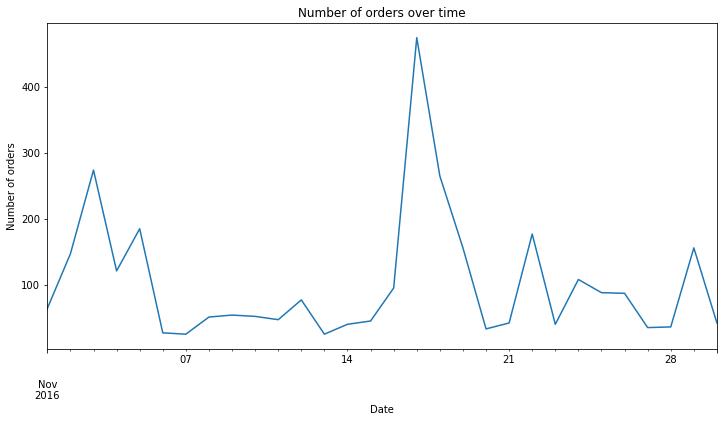

In [316]:
df.groupby('order_date').order_amount.count().plot(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.title('Number of orders over time')
plt.savefig('number_of_orders_over_time.png')
plt.show()

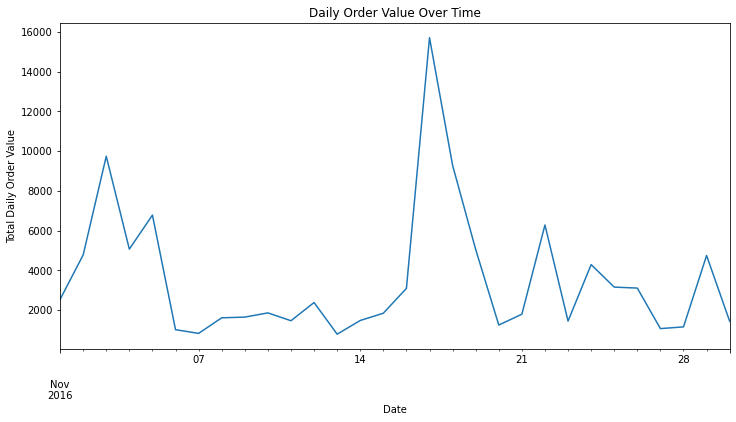

In [319]:
df.groupby('order_date').order_amount.sum().plot(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Total Daily Order Value')
plt.title('Daily Order Value Over Time')
plt.savefig('daily_order_value_over_time.png')
plt.show()

Examine the spike on the 17th  

In [366]:
df[df.order_date == '2016-11-17'].geom.value_counts().head()

51.803999999999995,-0.816                84
51.81399999999999,-0.8240000000000001    59
51.798,-0.816                            52
51.555,-0.001                             9
51.403,-0.149                             7
Name: geom, dtype: int64

In [324]:
len(df[df.geom == '51.803999999999995,-0.816'])

84

The address used for the 84 orders was only used on this date.

In [332]:
df[df.order_date == '2016-11-17'].suburb.value_counts().head()

Southcourt      151
Walton Hall      53
no_suburb        23
Temple Mills      9
Chigwell          8
Name: suburb, dtype: int64

In [339]:
df[df.suburb == 'Southcourt'].geom.value_counts()

51.803999999999995,-0.816                 84
51.81399999999999,-0.8240000000000001     59
51.803999999999995,-0.825                  6
51.803999999999995,-0.8240000000000001     2
Name: geom, dtype: int64

In [337]:
df[(df.order_date == '2016-11-17') & (df.suburb == 'Southcourt')].order_amount.sum()

4185.160000000001

151 of the orders came from Southcourt a small housing estate which includes the two most common addresses.

In [338]:
df[df.order_date == '2016-11-17'].town.value_counts().head()

Aylesbury             212
London                102
City of Nottingham     13
Erewash                 9
Leeds                   9
Name: town, dtype: int64

In [365]:
df[(df.order_date == '2016-11-17') & (df.town == 'London')].geom.value_counts().head()

51.555,-0.001                9
51.403,-0.149                7
51.565,-0.073                6
51.586999999999996,-0.023    3
51.525,0.0413                2
Name: geom, dtype: int64

In [371]:
df[(df.geom == '51.555,-0.001')].suburb.value_counts()

Temple Mills    9
Name: suburb, dtype: int64

Of the 102 London orders, 9 had the same delivery details, a property in Temple Mills. 

Let's look at the second highest peak in the month, on the 3rd of November.

In [364]:
df[(df.order_date == '2016-11-03')].geom.value_counts().head()

51.41,-0.158                               16
52.387,-1.247                              15
51.622,-3.95                               12
51.403999999999996,-0.09699999999999999    10
51.28,1.0769                                6
Name: geom, dtype: int64

In [388]:
df[df.geom == '51.41,-0.158'].suburb.value_counts()

Mitcham    16
Name: suburb, dtype: int64

In [389]:
df[df.geom == '52.387,-1.247'].suburb.value_counts()

Brownsover    15
Name: suburb, dtype: int64

In [363]:
df[(df.order_date == '2016-11-03')].suburb.value_counts().head()

no_suburb         21
Mitcham           16
Brownsover        15
Thornton Heath    13
Mount Pleasant    12
Name: suburb, dtype: int64

In [392]:
len(df[(df.order_date == '2016-11-03')&(df.suburb == 'no_suburb')].geom.value_counts())

18

In [382]:
df[(df.order_date == '2016-11-03')].town.value_counts().head()

London        148
Rugby          15
Swansea        13
Manchester     12
Birmingham     10
Name: town, dtype: int64

Individual order values

In [407]:
df.order_amount.describe()

count    3069.000000
mean       34.774718
std        20.551237
min         1.230000
25%        22.510000
50%        29.830000
75%        41.440000
max       353.920000
Name: order_amount, dtype: float64

In [408]:
df.order_amount.sum()

106723.61

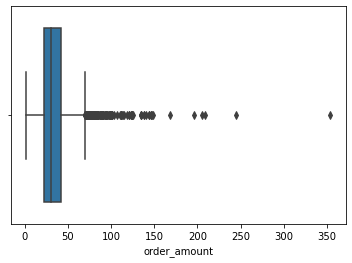

In [411]:
sns.boxplot(df.order_amount)

In [409]:
df.order_amount.mean() + 2* df.order_amount.std()

75.87719241757236

In [396]:
df[df.order_amount > (df.order_amount.mean() + 2* df.order_amount.std())].order_amount.sum()

11635.56

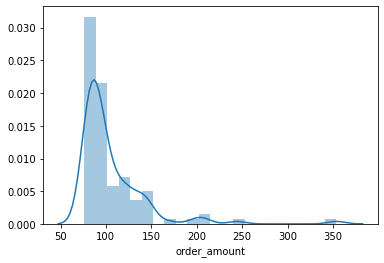

In [406]:
sns.distplot(df[df.order_amount > (df.order_amount.mean() + 2* df.order_amount.std())].order_amount)
plt.show()

In [438]:
df[df.order_amount > (df.order_amount.mean() + 2* df.order_amount.std())].district.value_counts()

Greater London              62
North West England          11
West Midlands               10
East Midlands                7
South East                   7
East of England              6
Yorkshire and the Humber     3
Scotland                     2
Cymru / Wales                1
South West England           1
Name: district, dtype: int64

In [439]:
df[df.order_amount == df.order_amount.max()]

,order_id,order_amount,delivery_latitude,delivery_longitude,order_date,geom,address,raw_address,nation,district,county,town,suburb,postcode
2422,ord-55344,353.92,50.843,-0.194,2016-11-04,"50.843,-0.19399999999999998","(Elm Drive, Hangleton, Hove, Brighton and Hove...","{'place_id': 83961007, 'licence': 'Data © Open...",England,South East,Brighton and Hove,Hove,Hangleton,BN3 7JE


In [372]:
import seaborn as sns

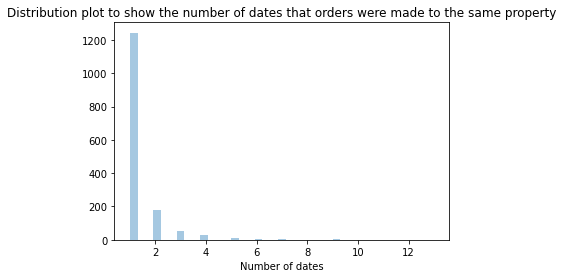

In [381]:
sns.distplot(df.groupby('geom').order_date.nunique().values, kde = False)
plt.xlabel('Number of dates')
plt.title('Distribution plot to show the number of dates that orders were made to the same property')
plt.show()

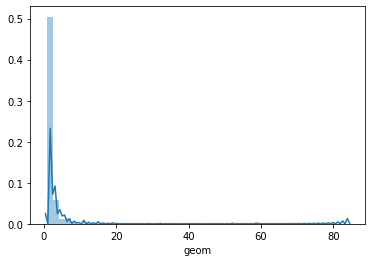

In [387]:
sns.distplot(df.geom.value_counts())

Look at the data on a nation wide level.

In [465]:
nations = df.groupby('nation').order_amount.describe()

nations['sum'] = df.groupby('nation').order_amount.sum()
nations['sum_rank'] = nations['sum'].rank(ascending = False)
nations['count_rank'] = nations['count'].rank(ascending = False)
nations.sort_values(by= 'sum', ascending = False)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
nation,,,,,,,,,,,
England,2943.0,35.012484,20.720509,1.23,22.735,30.15,41.66,353.92,103041.74,1.0,1.0
Scotland,85.0,29.508235,16.475716,11.30,19.150,24.29,34.69,97.67,2508.20,2.0,2.0
Cymru / Wales,41.0,28.626098,12.028751,15.91,21.140,24.64,31.17,82.69,1173.67,3.0,3.0


#### England has the highest count of fraudulent orders, and the largest combined total of order value.

In [466]:
districts = df.groupby('district').order_amount.describe()

districts['sum'] = df.groupby('district').order_amount.sum()
districts['sum_rank'] = districts['sum'].rank(ascending = False)
districts['count_rank'] = districts['count'].rank(ascending = False)

districts.sort_values(by = 'sum', ascending = False)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
district,,,,,,,,,,,
Greater London,1278.0,37.814890,21.603811,1.43,24.9500,33.130,44.6950,244.42,48327.43,1.0,1.0
South East,442.0,32.570294,22.359925,4.69,22.4600,28.010,38.7600,353.92,14396.07,2.0,2.0
North West England,292.0,34.109863,19.591955,6.40,21.2425,29.095,38.3550,140.53,9960.08,3.0,3.0
West Midlands,251.0,32.309124,21.598629,1.23,21.0550,26.750,34.9800,167.79,8109.59,4.0,4.0
East Midlands,224.0,33.578437,17.937014,6.82,22.2150,28.695,38.1825,124.61,7521.57,5.0,5.0
Yorkshire and the Humber,190.0,30.469000,15.153413,10.61,19.4800,27.680,35.3525,100.03,5789.11,6.0,6.0
East of England,157.0,35.705159,18.625930,8.28,22.9200,31.070,44.8100,137.76,5605.71,7.0,7.0
Scotland,85.0,29.508235,16.475716,11.30,19.1500,24.290,34.6900,97.67,2508.20,8.0,8.0
South West England,65.0,34.345077,18.388750,10.97,22.0200,30.840,40.0100,124.27,2232.43,9.0,9.0


In [467]:
counties = df.groupby('county').order_amount.describe()

counties['sum'] = df.groupby('county').order_amount.sum()
counties['sum_rank'] = counties['sum'].rank(ascending = False)
counties['count_rank'] = counties['count'].rank(ascending = False)


counties.sort_values(by = 'sum', ascending = False).head(5)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
county,,,,,,,,,,,
Greater London,1278.0,37.814890,21.603811,1.43,24.950,33.130,44.6950,244.42,48327.43,1.0,1.0
West Midlands Combined Authority,204.0,33.426618,23.264190,1.23,21.770,27.635,34.9100,167.79,6819.03,2.0,3.0
Buckinghamshire,223.0,29.132197,10.030476,13.60,22.185,26.840,34.9700,74.04,6496.48,3.0,2.0
Greater Manchester,154.0,33.844026,18.697310,6.40,21.650,28.830,37.7675,111.40,5211.98,4.0,4.0
West Yorkshire,126.0,29.940000,14.411824,10.61,19.185,25.815,35.8025,76.09,3772.44,5.0,5.0


In [499]:
counties.sort_values(by = 'sum', ascending = False).head(5)['sum'].sum()/df.order_amount.sum()

0.6617782138366565

In [501]:
counties.sort_values(by = 'count', ascending = False).head(5)['count'].sum()/df.order_amount.count()

0.6467904855001629

In [468]:
towns = df.groupby('town').order_amount.describe()

towns['sum'] = df.groupby('town').order_amount.sum()
towns['sum_rank'] = towns['sum'].rank(ascending = False)
towns['count_rank'] = towns['count'].rank(ascending = False)


towns.sort_values(by = 'sum', ascending = False).head(5)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
town,,,,,,,,,,,
London,1254.0,37.696826,21.505671,1.43,24.8700,33.060,44.6950,244.42,47271.82,1.0,1.0
Aylesbury,213.0,28.699437,9.366863,13.60,21.8000,26.220,34.4000,65.50,6112.98,2.0,2.0
Birmingham,128.0,31.302812,19.137862,1.23,21.6075,26.575,33.1475,123.82,4006.76,3.0,3.0
Leeds,76.0,28.642895,14.014500,10.61,17.9800,25.290,33.6425,76.09,2176.86,4.0,4.0
Leicester,63.0,34.283175,18.184072,6.82,24.5400,29.170,40.3750,124.61,2159.84,5.0,5.0


In [500]:
towns.sort_values(by = 'sum', ascending = False).head(5)['sum'].sum()/df.order_amount.sum()

0.5783936656565488

In [502]:
towns.sort_values(by = 'count', ascending = False).head(5)['count'].sum()/df.order_amount.count()

0.5650048875855328

In [481]:
suburbs = df.groupby('suburb').order_amount.describe()

suburbs['sum'] = df.groupby('suburb').order_amount.sum()
suburbs['sum_rank'] = suburbs['sum'].rank(ascending = False)
suburbs['count_rank'] = suburbs['count'].rank(ascending = False)


suburbs.sort_values(by = 'sum', ascending = False).head(11)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
suburb,,,,,,,,,,,
no_suburb,444.0,36.388176,20.406036,2.17,23.6825,31.150,43.5925,148.78,16156.35,1.0,1.0
Southcourt,151.0,27.716291,8.920585,13.60,20.9700,25.790,32.6850,62.01,4185.16,2.0,2.0
Walton Hall,53.0,30.563962,10.370514,13.80,22.6100,28.180,38.4900,65.50,1619.89,3.0,3.0
Wanstead Slip,40.0,38.976250,14.237641,17.44,27.2875,39.750,49.1750,71.43,1559.05,4.0,4.0
Mitcham,28.0,42.842500,18.149285,14.78,36.1300,43.285,47.3575,106.41,1199.59,5.0,7.0
Thornton Heath,29.0,36.766552,13.605208,12.22,27.8300,36.790,43.8600,63.42,1066.23,6.0,6.0
Hangleton,16.0,58.689375,90.888509,18.18,22.3350,24.675,33.9225,353.92,939.03,7.0,19.0
Moseley,35.0,25.432857,5.540726,17.17,21.8650,25.130,29.1500,41.61,890.15,8.0,5.0
Tottenham,21.0,40.910000,15.917747,16.13,30.5700,36.090,46.9200,90.95,859.11,9.0,10.0


In [482]:
suburbs.sort_values(by = 'sum', ascending = False).head(10).iloc[1:12]['sum'].sum()

13126.04

In [493]:
print(f'''Tackling the top 10 labelled suburbs could reduce up to {round((suburbs.sort_values(by = 'sum', 
                          ascending = False).head(10).iloc[1:12]['sum'].sum() / df.order_amount.sum())*100,2)}% of losses due to fraudulent transactions.''')

Tackling the top 10 labelled suburbs could reduce up to 12.3% of losses due to fraudulent transactions.


In [495]:
print(suburbs.sort_values(by = 'count', ascending = False).head(10).iloc[1:12]['count'].sum())

401.0


In [497]:
print(f'''Tackling the top 10 labelled suburbs could reduce up to {round((suburbs.sort_values(by = 'count', 
                          ascending = False).head(10).iloc[1:12]['count'].sum() / df.order_amount.count())*100,2)}% of the number of fraudulent transactions.''')

Tackling the top 10 labelled suburbs could reduce up to 13.07% of the number of fraudulent transactions.


In [473]:
df[df.county == 'Greater London'].town.value_counts()

London                 1254
City of Westminster      24
Name: town, dtype: int64

In [474]:
df[df.suburb == 'no_suburb'].town.value_counts().head()

London        278
Manchester     14
Birmingham     13
Charnwood      11
Elmbridge       9
Name: town, dtype: int64

In [510]:
no_sub = df[df.suburb == 'no_suburb'].groupby('town').order_amount.describe()

no_sub['sum'] = df[df.suburb == 'no_suburb'].groupby('town').order_amount.sum()
no_sub['sum_rank'] = no_sub['sum'].rank(ascending = False)
no_sub['count_rank'] = no_sub['count'].rank(ascending = False)


no_sub.sort_values(by = 'sum', ascending = False).head(11)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
town,,,,,,,,,,,
London,278.0,36.911942,19.393749,2.17,24.7275,33.015,44.0650,148.78,10261.52,1.0,1.0
Manchester,14.0,38.780000,20.264548,9.16,23.4200,38.115,50.7500,80.71,542.92,2.0,2.0
Sandwell,7.0,53.592857,42.812574,23.99,30.5000,35.580,55.3600,143.86,375.15,3.0,6.0
Birmingham,13.0,27.184615,6.769213,17.87,23.3800,26.900,31.1500,41.23,353.40,4.0,3.0
Halesowen,6.0,55.491667,53.066939,16.20,21.0925,27.555,81.0875,143.77,332.95,5.0,8.0
Castle Point,4.0,81.887500,13.291888,62.74,79.5175,85.670,88.0400,93.47,327.55,6.0,14.0
Charnwood,11.0,26.258182,11.693581,16.92,18.9200,21.830,26.5850,51.31,288.84,7.0,4.0
Elmbridge,9.0,30.807778,7.328768,20.55,26.3500,31.010,34.3000,43.81,277.27,8.0,5.0
Hindley,6.0,38.078333,23.116450,16.91,21.7450,28.000,56.9050,69.36,228.47,9.0,8.0


In [475]:
properties = df.groupby('geom').order_amount.describe()

properties['sum'] = df.groupby('geom').order_amount.sum()
properties['sum_rank'] = properties['sum'].rank(ascending = False)
properties['count_rank'] = properties['count'].rank(ascending = False)


properties.sort_values(by = 'sum', ascending = False).head(10)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
geom,,,,,,,,,,,
"51.803999999999995,-0.816",84.0,26.735476,7.498836,16.23,21.7475,25.715,29.5300,55.27,2245.78,1.0,1.0
"51.573,-0.408",59.0,34.631017,9.232277,18.66,26.9400,32.850,42.1000,58.95,2043.23,2.0,2.5
"51.81399999999999,-0.8240000000000001",59.0,27.991017,10.504317,13.60,19.1450,24.050,34.3450,62.01,1651.47,3.0,2.5
"51.798,-0.816",52.0,30.301538,10.292467,13.80,22.5025,28.080,37.8825,65.50,1575.68,4.0,4.0
"51.56,0.013999999999999999",32.0,41.405938,14.623149,17.44,27.9025,44.745,50.0400,71.43,1324.99,5.0,5.0
"52.452,-1.8869999999999998",29.0,25.267586,5.124353,17.17,21.7100,25.680,29.4300,35.00,732.76,6.0,6.0
"50.843,-0.19399999999999998",14.0,50.592857,87.912216,18.18,21.6450,23.505,31.4625,353.92,708.30,7.0,12.0
"51.41,-0.158",16.0,42.353750,4.337929,35.64,39.3925,43.390,45.0550,48.29,677.66,8.0,8.0
"51.376000000000005,-0.39799999999999996",19.0,33.618947,7.596165,22.19,29.0850,32.890,35.7000,52.49,638.76,9.0,7.0


In [476]:
properties.sort_values(by = 'count', ascending = False).head(10)

,count,mean,std,min,25%,50%,75%,max,sum,sum_rank,count_rank
geom,,,,,,,,,,,
"51.803999999999995,-0.816",84.0,26.735476,7.498836,16.23,21.7475,25.715,29.5300,55.27,2245.78,1.0,1.0
"51.573,-0.408",59.0,34.631017,9.232277,18.66,26.9400,32.850,42.1000,58.95,2043.23,2.0,2.5
"51.81399999999999,-0.8240000000000001",59.0,27.991017,10.504317,13.60,19.1450,24.050,34.3450,62.01,1651.47,3.0,2.5
"51.798,-0.816",52.0,30.301538,10.292467,13.80,22.5025,28.080,37.8825,65.50,1575.68,4.0,4.0
"51.56,0.013999999999999999",32.0,41.405938,14.623149,17.44,27.9025,44.745,50.0400,71.43,1324.99,5.0,5.0
"52.452,-1.8869999999999998",29.0,25.267586,5.124353,17.17,21.7100,25.680,29.4300,35.00,732.76,6.0,6.0
"51.376000000000005,-0.39799999999999996",19.0,33.618947,7.596165,22.19,29.0850,32.890,35.7000,52.49,638.76,9.0,7.0
"51.41,-0.158",16.0,42.353750,4.337929,35.64,39.3925,43.390,45.0550,48.29,677.66,8.0,8.0
"52.387,-1.247",15.0,20.310000,3.612704,15.30,18.3200,19.500,21.8050,30.29,304.65,28.0,10.0
